In [1]:
#import dependency
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import requests
import psycopg2
import config as creds


In [2]:
# Import our input dataset
#ames_df = pd.read_csv('Resources/ames_raw.csv', keep_default_na=False)
ames_df = pd.read_csv('Resources/ames_raw.csv')
ames_df.head()

,Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
ames_df

,Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [4]:
# Drop 1st column
ames_df = ames_df.drop(ames_df.columns[0], axis=1)

# **Step 1: Data Exploration**
* Check the dataset
* check the missing values and duplicates
* check the columns
* check the types
* check the shape

In [5]:
ames_df.dtypes

Order               int64
PID                 int64
MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
                   ...   
Mo Sold             int64
Yr Sold             int64
Sale Type          object
Sale Condition     object
SalePrice           int64
Length: 82, dtype: object

In [6]:
# Rename Columns
ames_df.columns = ['ames_order','pid','mssubclass','mszoning','lotfrontage','lotarea','street','alley','lotshape','landcontour', \
                   'utilities','lotconfig','landslope','neighborhood','condition1','condition2','bldgtype','housestyle',\
                   'overallqual','overallcond','yearbuilt','yearremodadd','roofstyle','roofmatl','exterior1st','exterior2nd',\
                   'masvnrtype','masvnrarea','exterqual','extercond','foundation','bsmtqual','bsmtcond','bsmtexposure',\
                   'bsmtfintype1','bsmtfinsf1','bsmtfintype2','bsmtfinsf2','bsmtunfsf','totalbsmtsf','heating','heatingqc',\
                   'centralair','electrical','1stflrsf','2ndflrsf','lowqualfinsf','grlivarea','bsmtfullbath','bsmthalfbath',\
                   'fullbath','halfbath','bedroomabvgr','kitchenabvgr','kitchenqual','totrmsabvgrd','functional','fireplaces',\
                   'fireplacequ','garagetype','garageyrblt','garagefinish','garagecars','garagearea','garagequal','garagecond',\
                   'paveddrive','wooddecksf','openporchsf','enclosedporch','3ssnporch','screenporch','poolarea','poolqc','fence',\
                   'miscfeature','miscval','mosold','yrsold','saletype','salecondition','saleprice']
ames_df.head(5)

,ames_order,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


**Data Explorarion Summary:**
* There are multiple types of features, both categorical and numerical
* Tratget is numerical
* There are missing values in the dataset


# **Step 2: Data cleaning:**

* remove null value or replace it with the mode of their respective columns
* remove duplicate if any
* create new feature to combine features that are in the same category


In [7]:
# Check df shape and columns
print(ames_df.shape[0])
print(ames_df.columns)

2930
Index(['ames_order', 'pid', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea',
       'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'gara

In [8]:
#check missing data ratio
missing_1 = (ames_df.isnull().sum()/ len(ames_df)) * 100
missing_1 = missing_1.drop(missing_1[missing_1 ==0].index).sort_values(ascending=False)[:30]
missing_1

poolqc          99.556314
miscfeature     96.382253
alley           93.242321
fence           80.477816
fireplacequ     48.532423
lotfrontage     16.723549
garageyrblt      5.426621
garagecond       5.426621
garagequal       5.426621
garagefinish     5.426621
garagetype       5.358362
bsmtexposure     2.832765
bsmtfintype2     2.764505
bsmtcond         2.730375
bsmtqual         2.730375
bsmtfintype1     2.730375
masvnrtype       0.784983
masvnrarea       0.784983
bsmthalfbath     0.068259
bsmtfullbath     0.068259
garagecars       0.034130
bsmtfinsf2       0.034130
bsmtfinsf1       0.034130
bsmtunfsf        0.034130
totalbsmtsf      0.034130
garagearea       0.034130
electrical       0.034130
dtype: float64

**remove/replace NA**


In [9]:
# Drop Columns more than 20% of the data is missing
ames_df = ames_df.drop((missing_1[missing_1 > 20]).index,1)

In [10]:
ames_df['mszoning'].value_counts()

RL         2273
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: mszoning, dtype: int64

In [11]:
#Just keep the residential properties
a = ['C (all)','I (all)', 'FV', 'A (agr)']
for i in a:
    ames_df.drop(ames_df[ames_df['mszoning'] == i].index, inplace = True)
    
# ames_df.drop(ames_df[ames_df['mszoning'] =='FV'].index, inplace = True)
ames_df['mszoning'].value_counts()

RL    2273
RM     462
RH      27
Name: mszoning, dtype: int64

In [12]:
#Replace null values with o for garageyrblt, garagearea and garagecars with 0
for col in ('garageyrblt', 'garagearea', 'garagecars'):
  ames_df[col] = ames_df[col].fillna(0)

In [13]:
#Fill missing values in masvnrarea and masvnrtype with mode
ames_df['masvnrarea'].value_counts()
ames_df['masvnrarea'] = ames_df['masvnrarea'].fillna(ames_df['masvnrarea'].mode()[0])
ames_df['masvnrtype'].value_counts()
ames_df['masvnrtype'] = ames_df['masvnrtype'].fillna(ames_df['masvnrtype'].mode()[0])

In [14]:
ames_df['bsmthalfbath'].value_counts()
ames_df['bsmthalfbath'] = ames_df['bsmthalfbath'].fillna(ames_df['bsmthalfbath'].mode()[0])
ames_df['bsmtfullbath'].value_counts()
ames_df['bsmtfullbath'] = ames_df['bsmtfullbath'].fillna(ames_df['bsmtfullbath'].mode()[0])

In [15]:
# null values saleprice are due to missing saleprice column in the test dataset
# we will replace missing values in lotfrontage with median lotfrontage of neighberhood 
ames_df['lotfrontage'] = ames_df.groupby('neighborhood')['lotfrontage'].transform(
      lambda x: x.fillna(x.median()))

In [16]:
ames_df["utilities"].value_counts()
# drop the entire column since it only doesn't help with prediction
ames_df = ames_df.drop(['utilities'], axis=1)

In [17]:
ames_df["electrical"].value_counts()
ames_df["electrical"] = ames_df["electrical"].fillna(ames_df["electrical"].mode()[0])

In [18]:
basement = ["totalbsmtsf", "bsmtunfsf", "bsmtfinsf2", "bsmtfinsf1"]
for i in basement:
  print(ames_df[i].value_counts())
  ames_df[i] = ames_df[i].fillna(ames_df[i].mode()[0])

0.0       75
864.0     73
672.0     28
1040.0    25
912.0     25
          ..
484.0      1
372.0      1
2320.0     1
348.0      1
1061.0     1
Name: totalbsmtsf, Length: 1028, dtype: int64
0.0       238
384.0      19
728.0      14
672.0      13
816.0      11
         ... 
91.0        1
1072.0      1
1248.0      1
1568.0      1
557.0       1
Name: bsmtunfsf, Length: 1101, dtype: int64
0.0      2414
294.0       5
180.0       5
72.0        3
435.0       3
         ... 
35.0        1
154.0       1
106.0       1
488.0       1
530.0       1
Name: bsmtfinsf2, Length: 272, dtype: int64
0.0       856
24.0       20
16.0       13
300.0       9
288.0       8
         ... 
822.0       1
826.0       1
607.0       1
469.0       1
1013.0      1
Name: bsmtfinsf1, Length: 971, dtype: int64


In [19]:
#Check if there is any duplicates
ames_df.duplicated().sum()

0

In [20]:
# combine an important feature - total_area
ames_df['total_area'] = ames_df['totalbsmtsf'] + ames_df['1stflrsf'] + ames_df['2ndflrsf'] + ames_df['grlivarea'] + ames_df['garagearea']


In [21]:
#check if the new column was addedd
ames_df

,ames_order,pid,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,lotconfig,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,Corner,...,0,0,0,0,5,2010,WD,Normal,215000,4920.0
1,2,526350040,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,...,0,120,0,0,6,2010,WD,Normal,105000,3404.0
2,3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,...,0,0,0,12500,6,2010,WD,Normal,172000,4299.0
3,4,526353030,20,RL,93.0,11160,Pave,Reg,Lvl,Corner,...,0,0,0,0,4,2010,WD,Normal,244000,6852.0
4,5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,...,0,0,0,0,3,2010,WD,Normal,189900,4668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,IR1,Lvl,CulDSac,...,0,0,0,0,3,2006,WD,Normal,142500,3597.0
2926,2927,923276100,20,RL,74.0,8885,Pave,IR1,Low,Inside,...,0,0,0,0,6,2006,WD,Normal,131000,3152.0
2927,2928,923400125,85,RL,62.0,10441,Pave,Reg,Lvl,Inside,...,0,0,0,700,7,2006,WD,Normal,132000,2852.0
2928,2929,924100070,20,RL,77.0,10010,Pave,Reg,Lvl,Inside,...,0,0,0,0,4,2006,WD,Normal,170000,4585.0


In [22]:
#check missing data ratio again to see what's left
missing_2 = (ames_df.isnull().sum()/ len(ames_df)) * 100
missing_2 = missing_2.drop(missing_2[missing_2 ==0].index).sort_values(ascending=False)[:30]
missing_2

garagecond      5.394642
garagequal      5.394642
garagefinish    5.394642
garagetype      5.322230
bsmtexposure    2.824041
bsmtfintype2    2.787835
bsmtfintype1    2.751629
bsmtcond        2.751629
bsmtqual        2.751629
lotfrontage     0.108617
dtype: float64

In [23]:
# Drop Columns more than 2% of the data is missing
ames_df = ames_df.drop((missing_2[missing_2 > .1]).index,1)

In [24]:
#dropping any NA before putting the dataset into our model
ames_df = ames_df.dropna()
ames_df.isnull().sum()

ames_order       0
pid              0
mssubclass       0
mszoning         0
lotarea          0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 67, dtype: int64

In [25]:
ames_df

,ames_order,pid,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,...,0,0,0,0,5,2010,WD,Normal,215000,4920.0
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,...,0,120,0,0,6,2010,WD,Normal,105000,3404.0
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,...,0,0,0,12500,6,2010,WD,Normal,172000,4299.0
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,...,0,0,0,0,4,2010,WD,Normal,244000,6852.0
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,...,0,0,0,0,3,2010,WD,Normal,189900,4668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,...,0,0,0,0,3,2006,WD,Normal,142500,3597.0
2926,2927,923276100,20,RL,8885,Pave,IR1,Low,Inside,Mod,...,0,0,0,0,6,2006,WD,Normal,131000,3152.0
2927,2928,923400125,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,700,7,2006,WD,Normal,132000,2852.0
2928,2929,924100070,20,RL,10010,Pave,Reg,Lvl,Inside,Mod,...,0,0,0,0,4,2006,WD,Normal,170000,4585.0


In [26]:
# Check numerical columns
numerical = ames_df.select_dtypes(exclude='object')
numerical.columns

Index(['ames_order', 'pid', 'mssubclass', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'saleprice', 'total_area'],
      dtype='object')

In [27]:
# Change numerical columns
ames_df[['pid', 'mssubclass', 'overallqual','overallcond']] = ames_df[['pid', 'mssubclass', 'overallqual','overallcond']].astype(object)

In [28]:
#Check for catorgorical columns
categorical = ames_df.select_dtypes('object')
categorical.columns

Index(['pid', 'mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'saletype',
       'salecondition'],
      dtype='object')

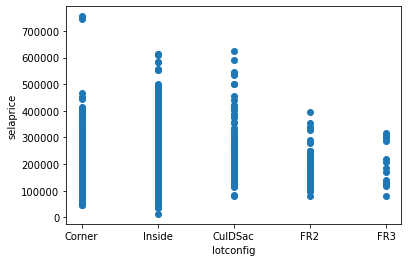

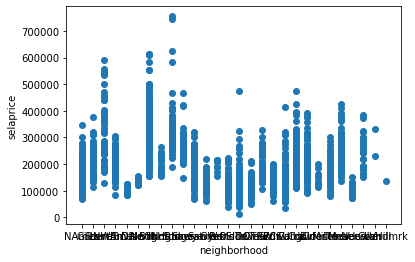

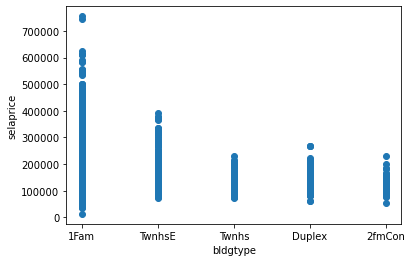

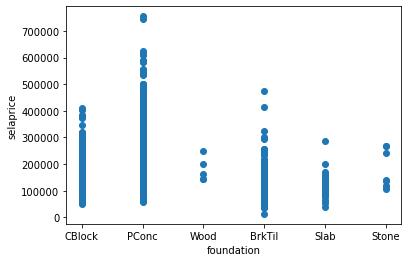

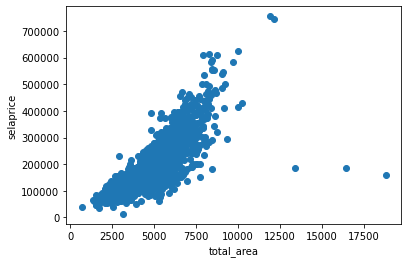

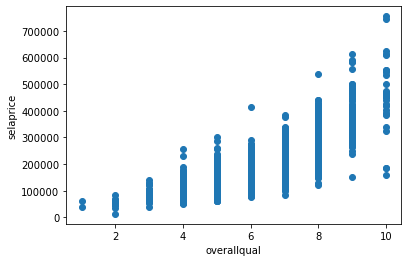

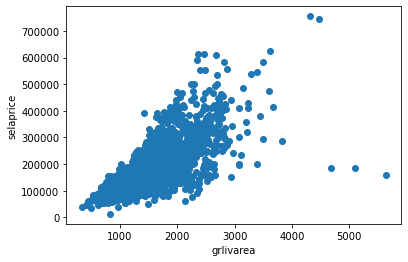

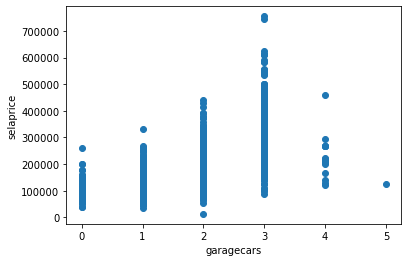

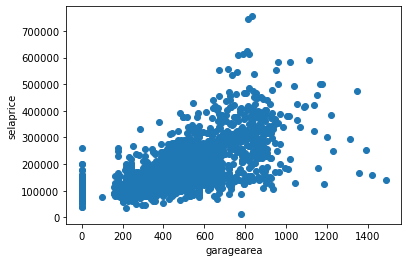

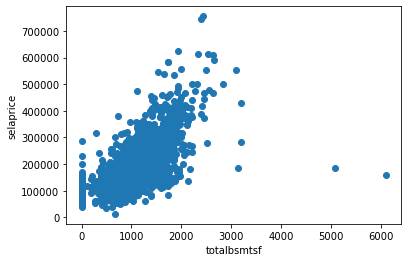

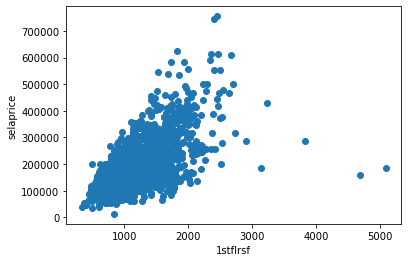

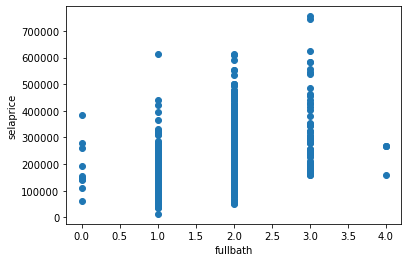

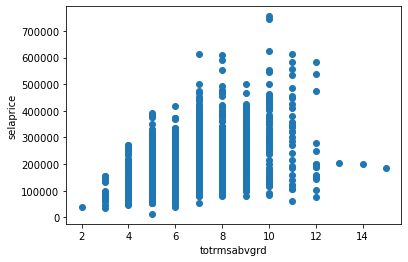

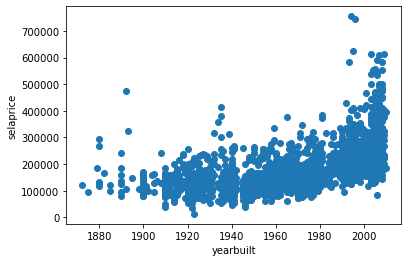

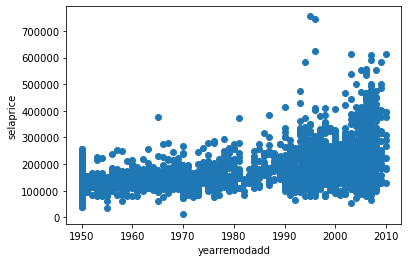

In [29]:
x_features = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(ames_df[x], ames_df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()
    



# **Step 3: Feature Selection:**
* Use heatmap to identify features that are most correlated to the Sales Price


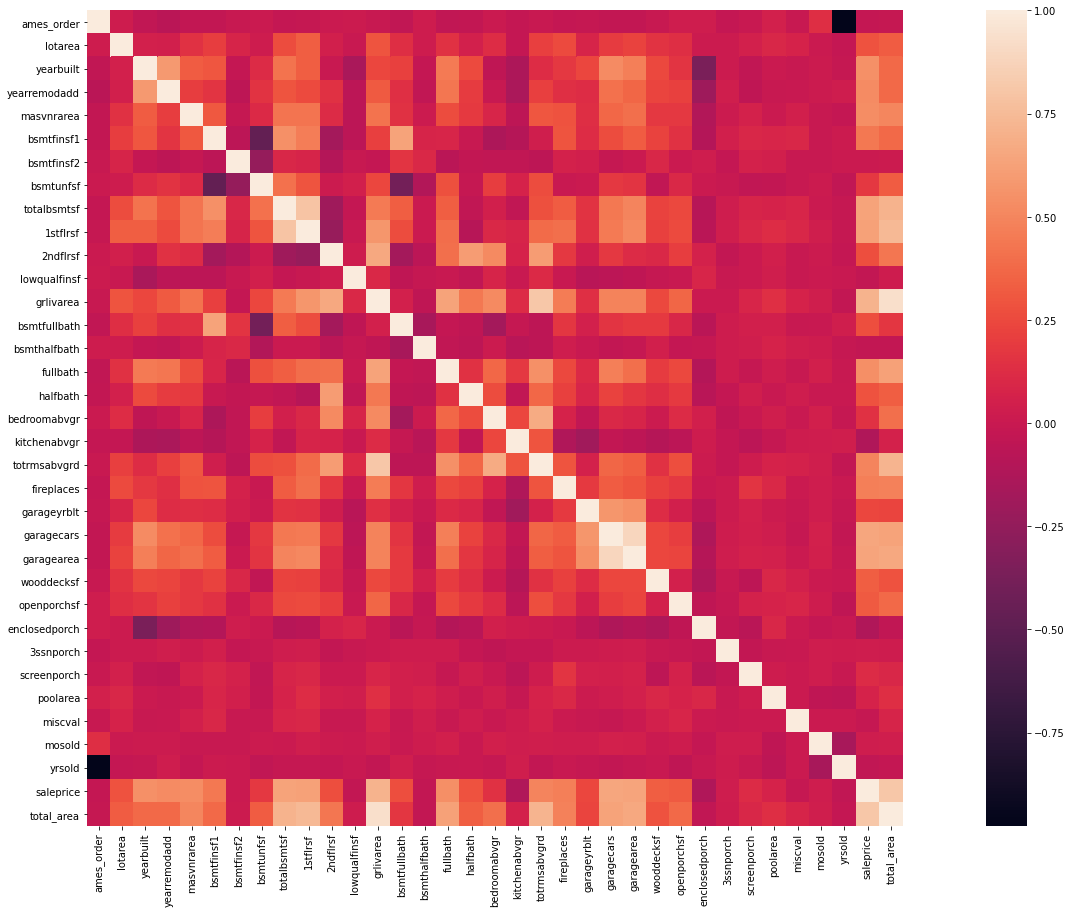

In [30]:
corrmat = ames_df.corr()
f, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(corrmat, vmax=1, square=True)


In [31]:
corrmat_2 = corrmat['saleprice'].sort_values(ascending=False).head(12).to_frame()

cm = sns.light_palette("purple", as_cmap=True)

corrmat_3 = corrmat_2.style.background_gradient(cmap=cm)
corrmat_3


,saleprice
saleprice,1.000000
total_area,0.808044
grlivarea,0.706840
garagecars,0.645240
garagearea,0.638691
totalbsmtsf,0.631792
1stflrsf,0.629236
yearbuilt,0.550205
fullbath,0.541701
masvnrarea,0.535076


# **Initial Features Selection**
we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5)

* overallqual_id
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* LotConfig
* Neighborhood
* BldgType
* Foundation
Noted: we will try different combination to determine the final features selected in machine learning step

Export cleaned dataset

In [32]:
#Converting float to int
temp = ames_df.loc[:, ames_df.dtypes == np.float64]
columns = list(temp.columns)

#loop through all columns
for col in columns:
  ames_df[col] = ames_df[col].astype(np.int64)

#Check to float columns
# select the float columns
df_float = ames_df.select_dtypes(include=[np.float])
# select non-numeric columns
df_float

""
0
1
2
3
4
...
2925
2926
2927
2928


In [33]:
# Check dataframe to make sure everything looks ok
ames_df

,ames_order,pid,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,...,0,0,0,0,5,2010,WD,Normal,215000,4920
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,...,0,120,0,0,6,2010,WD,Normal,105000,3404
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,...,0,0,0,12500,6,2010,WD,Normal,172000,4299
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,...,0,0,0,0,4,2010,WD,Normal,244000,6852
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,...,0,0,0,0,3,2010,WD,Normal,189900,4668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,...,0,0,0,0,3,2006,WD,Normal,142500,3597
2926,2927,923276100,20,RL,8885,Pave,IR1,Low,Inside,Mod,...,0,0,0,0,6,2006,WD,Normal,131000,3152
2927,2928,923400125,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,700,7,2006,WD,Normal,132000,2852
2928,2929,924100070,20,RL,10010,Pave,Reg,Lvl,Inside,Mod,...,0,0,0,0,4,2006,WD,Normal,170000,4585


In [34]:
# Connection string for the AWS PostgreSQL database
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                 +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    #print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor


In [35]:
# Create function to write to database
import os
def copy_from_file(conn, df, table, filename):
    """
    Here we are going save the dataframe on disk as 
    a csv file, load the csv file  
    and use copy_from() to copy it to the table
    """
    # Save the dataframe to disk
    tmp_df = filename #"./tmp_dataframe.csv"
    df.to_csv(tmp_df, header=False, index=False)
    f = open(tmp_df, 'r')
    cursor = conn.cursor()
    try:
        cursor.copy_from(f, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        os.remove(tmp_df)
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("copy_from_file() done")
    cursor.close()
    #os.remove(tmp_df)

In [36]:
#------------------------------------------------------------------------------------------
# Call copy_from_file function to write to ames table
#------------------------------------------------------------------------------------------
conn, cursor = connect() # connect to the database
copy_from_file(conn, ames_df, 'ames', 'Resources/cleaned_dataset.csv') # copy the dataframe to SQL

PermissionError: [WinError 32] 程序無法存取檔案，因為檔案正由另一個程序使用。: 'Resources/cleaned_dataset.csv'

In [37]:
# Import our input dataset
#ames_df = pd.read_csv('Resources/ames_raw.csv', keep_default_na=False)
ames_geo_df = pd.read_csv('Resources/ames_geo.csv')
ames_geo_df.head()

,Unnamed: 0,PID,Longitude,Latitude
0,1,526301100,-93.619754,42.054035
1,2,526350040,-93.619756,42.053014
2,3,526351010,-93.619387,42.052659
3,4,526353030,-93.617320,42.051245
4,5,527105010,-93.638933,42.060899


In [38]:
#Check datatypes for ames_geo_df
ames_geo_df.dtypes

Unnamed: 0      int64
PID            object
Longitude     float64
Latitude      float64
dtype: object

In [39]:
# Rename columns
ames_geo_df.columns = ['geo_id','pid','longitude','latitude']
ames_geo_df

,geo_id,pid,longitude,latitude
0,1,526301100,-93.619754,42.054035
1,2,526350040,-93.619756,42.053014
2,3,526351010,-93.619387,42.052659
3,4,526353030,-93.617320,42.051245
4,5,527105010,-93.638933,42.060899
...,...,...,...,...
2927,2928,912251110,-93.588227,42.018300
2928,2929,904101170,-93.657031,42.031281
2929,2930,909201110,-93.647024,42.019272
2930,2931,522150020,-93.639276,42.073156


In [40]:
# Replace extra commas
ames_geo_df = ames_geo_df.replace(',','', regex=True)
# Replace leading zeros
ames_geo_df['pid'] = ames_geo_df['pid'].str.lstrip('0')
# Round decimal places to 6
ames_geo_df['longitude']=ames_geo_df['longitude'].round(decimals=6)
ames_geo_df['latitude']=ames_geo_df['latitude'].round(decimals=6)

In [41]:
# Change the data type of pid for ames_df to compare pid in both dataframes
ames_df['pid'] = ames_df['pid'].astype(np.str)

In [42]:
# Merge both dataframes
common = ames_df.merge(ames_geo_df, on=["pid"])
common

,ames_order,pid,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,...,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area,geo_id,longitude,latitude
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,...,0,5,2010,WD,Normal,215000,4920,1,-93.619754,42.054035
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,...,0,6,2010,WD,Normal,105000,3404,2,-93.619756,42.053014
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,...,12500,6,2010,WD,Normal,172000,4299,3,-93.619387,42.052659
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,...,0,4,2010,WD,Normal,244000,6852,4,-93.617320,42.051245
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,...,0,3,2010,WD,Normal,189900,4668,5,-93.638933,42.060899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,2926,923275080,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,...,0,3,2006,WD,Normal,142500,3597,73,-93.604776,41.988964
2748,2927,923276100,20,RL,8885,Pave,IR1,Low,Inside,Mod,...,0,6,2006,WD,Normal,131000,3152,74,-93.602680,41.988314
2749,2928,923400125,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,...,700,7,2006,WD,Normal,132000,2852,75,-93.606847,41.986510
2750,2929,924100070,20,RL,10010,Pave,Reg,Lvl,Inside,Mod,...,0,4,2006,WD,Normal,170000,4585,76,-93.600190,41.990921


In [43]:
# Get only the matched pid from both dataframes
ames_geo_df = ames_geo_df[ames_geo_df.pid.isin(common.pid)]
ames_geo_df

,geo_id,pid,longitude,latitude
0,1,526301100,-93.619754,42.054035
1,2,526350040,-93.619756,42.053014
2,3,526351010,-93.619387,42.052659
3,4,526353030,-93.617320,42.051245
4,5,527105010,-93.638933,42.060899
...,...,...,...,...
2911,2912,908102020,-93.678267,42.019586
2915,2916,906226090,-93.679109,42.031623
2923,2924,916252170,-93.645586,42.000966
2928,2929,904101170,-93.657031,42.031281


In [44]:
#------------------------------------------------------------------------------------------
# Call copy_from_file function to write to ames_ego table
#------------------------------------------------------------------------------------------
conn, cursor = connect() # connect to the database
copy_from_file(conn, ames_geo_df, 'ames_geo', 'Resources/cleaned_geo_dataset.csv') # copy the dataframe to SQL

PermissionError: [WinError 32] 程序無法存取檔案，因為檔案正由另一個程序使用。: 'Resources/cleaned_geo_dataset.csv'

In [ ]:
# Close database connection
conn.close() # close the connection

In [45]:
# Export csv file with header for website and tableau
ames_df.to_csv('Resources/cleaned_ames_dataset.csv', index=False)
ames_geo_df.to_csv('Resources/cleaned_ames_geo_dataset.csv', index=False)